In [1]:
# we import libraries useful for file management, audio elaboration and data analysis
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time

# we import libraries from scikit-learn in order to apply classification with Support Vector Machine
from sklearn.svm import SVC # model of Support Vector Classification
from sklearn.model_selection import train_test_split, GridSearchCV # tool to divide data in training and test and find the best combination of parameters
from sklearn.preprocessing import StandardScaler # tool to normalize data in order to obtain better performance with the model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix # metrics to evaluate our model performance and tools to show graphically the results

# Mount Google Drive if running in Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Define dataset path
#DATASET_PATH = "/content/drive/MyDrive/DSIM Project/gender"
DATASET_PATH = "/content/drive/MyDrive/Digital Signal/gender"
# Function to extract MFCC features
def extract_features(file_path, max_pad_length=50):
    try:
        audio, sr = librosa.load(file_path, sr=22050) # we load the audio file with a sampling frequency of 22050 Hz
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)  # we extract 13 MFFC features
        pad_width = max_pad_length - mfccs.shape[1]
        if pad_width > 0: # we want a fixed width
            mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant') #padding
        else:
            mfccs = mfccs[:, :max_pad_length]  # we trim if longer
        return np.mean(mfccs, axis=1)  # we take the mean of mfccs along the temporal axis
    except Exception as e: #error management
        print(f"Error extracting features from {file_path}: {e}")
        return None


In [3]:
# we prepare our dataset
X, y = [], []
labels = {'male': 0, 'female': 1}  # we assign labels to the two classes
gender_counts = {'male': 0, 'female': 0} # we initialize the counter to 0 for both classes

In [4]:
# we load audio files and extract features with the function defined above
for label, gender in labels.items(): #we get our files
    folder_path = os.path.join(DATASET_PATH, label)
    file_list = os.listdir(folder_path)
    for file in file_list:
        if gender_counts[label] >= 1000:  # we stop when 1000 samples are collected
            break
        file_path = os.path.join(folder_path, file)
        features = extract_features(file_path) # we estract the MFCC features
        if features is not None: # check if the extraction was successfully
            X.append(features)
            y.append(gender)
            gender_counts[label] += 1

In [5]:
# we convert our lists to NumPy arrays
X, y = np.array(X), np.array(y)

# we split into training and test sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# we standardize features to improve the performance during the training
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [6]:
# we set the parameters to be tested in cross-validation
param_grid = {'C': [100, 500, 1000],
          'gamma': [0.005, 0.01, 0.1, 0.5, 1.0], }

# we create a Support Vector Machine model with the Radial Basis Function kernel to perform the research of the best parameters. We use the 2-fold cross-validation.
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=2)

# we train the model with the best parameters and measure how it lasts
t0 = time()
clf = clf.fit(X_train, y_train)
print('Training completed in %0.3fs' % (time() - t0))

Training completed in 1.141s


In [7]:
# we print the result of the cross validation for parameters selection
print('Best parameters combination:')
print(' C: '+str(clf.best_estimator_.C))
print(' gamma: '+str(clf.best_estimator_.gamma))

Best parameters combination:
 C: 500
 gamma: 0.005


In [8]:
# we evaluate the model and print the metrics
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Model Accuracy: {accuracy:.2f}")
print("Classification Report:\n", classification_report(y_test, y_pred))

Model Accuracy: 0.99
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       199
           1       0.99      1.00      0.99       201

    accuracy                           0.99       400
   macro avg       0.99      0.99      0.99       400
weighted avg       0.99      0.99      0.99       400



In [9]:
# as we can see we obtained excellent results. The model has an accuracy equal to 99% and the same is for precision, recall and F1-score for the class male (0). Moreover for the
# class female we obtain a recall of 1. Also the macro averages and weighted averages are all equal to 0.99 meaning that the model dealt very well also with possible imbalances
# on the dataset.

Confusion matrix:


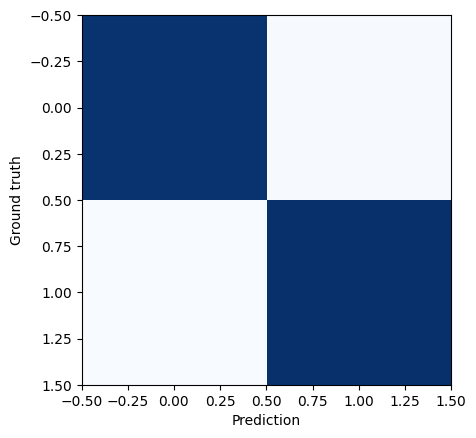

In [10]:
# we plot the confusion matrix to see graphically the results
print('Confusion matrix:')
cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm, cmap=plt.cm.Blues);
plt.xlabel('Prediction');
plt.ylabel('Ground truth');

In [11]:
# Of course the plot is pratically perfect, supporting what we highlighted before.

# Unseen audio

Evaluation on unseen audio data:
Accuracy: 0.83
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.97      0.85       500
           1       0.96      0.69      0.80       500

    accuracy                           0.83      1000
   macro avg       0.86      0.83      0.83      1000
weighted avg       0.86      0.83      0.83      1000



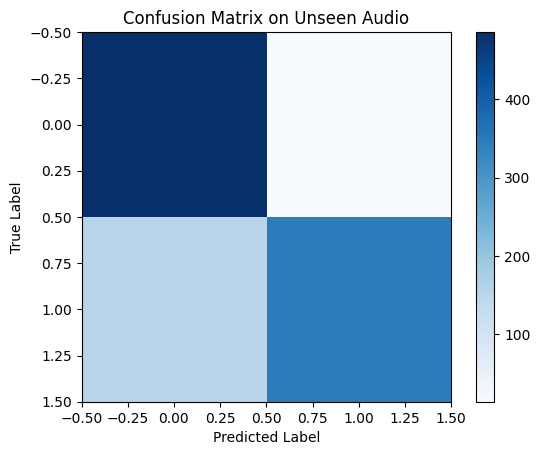

In [12]:
# we define how many samples we used for training/testing and for unseen evaluation
train_samples = 1000     # first 1000 samples per gender were used for train/test
unseen_samples = 500     # additional 500 samples per gender for unseen evaluation

# we set new lists to store features and labels for unseen audio
X_unseen = []
y_unseen = []

# we define 'labels' dictionary as before
labels = {'male': 0, 'female': 1}

# we loop over each gender folder and load the unseen audio files
for label, gender in labels.items():
    folder_path = os.path.join(DATASET_PATH, label)
    file_list = sorted(os.listdir(folder_path))  # we sort to ensure consistent ordering
    # we select files from index 1000 to 1499 (files that we did not use before)
    unseen_files = file_list[train_samples:train_samples + unseen_samples]

    for file in unseen_files:
        file_path = os.path.join(folder_path, file)
        features = extract_features(file_path)
        if features is not None:
            X_unseen.append(features)
            y_unseen.append(gender)

# as before we convert our lists to NumPy arrays
X_unseen = np.array(X_unseen)
y_unseen = np.array(y_unseen)

# IMPORTANT: we standardize the unseen features using the same StandardScaler fitted on your training data
X_unseen_scaled = scaler.transform(X_unseen)

# we use our trained classifier to predict the labels for the unseen audio
y_pred_unseen = clf.predict(X_unseen_scaled)

# as before we evaluate the predictions and plot the confusion matrix
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Evaluation on unseen audio data:")
print("Accuracy: {:.2f}".format(accuracy_score(y_unseen, y_pred_unseen)))
print("Classification Report:\n", classification_report(y_unseen, y_pred_unseen))

cm = confusion_matrix(y_unseen, y_pred_unseen)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title("Confusion Matrix on Unseen Audio")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.colorbar()
plt.show()


In [13]:
# as we can see from the confusion matrix and the metrics above we obtained worse results than before. We can see an almost equal reduction on the F1-score that suggests us
# that the model has lost some performance generally. More specifically for the class 0, the model generates more false positives even if predicts correctly most of the istances.
# On the contrary for the class 1 we can see a signficant reduction on the recall that means that the model is loosing lot of istances of the class 1 even if the value of the precision
# tells us that it is very accurate when it predicts the class 1. By the way, despite some worsening the model achieved an accuracy of 83% that is still a good value; however this
# can be caused by some patterns on new data that the model is not able to detect.

In [14]:
#MODEL SAVER
import joblib
joblib.dump(clf, '/content/drive/ My Drive/svm_model.pkl')

['/content/drive/ My Drive/svm_model.pkl']